# Milestone II: 
### Wizualizacja 3D, dobranie modelu, interpretacja klastrów

Wczytujemy dane

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/lila/Downloads/Brain_GSE50161.csv")

In [2]:
df.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,834,ependymoma,12.498150,7.604868,6.880934,9.027128,4.176175,7.224920,6.085942,6.835999,...,9.979005,9.926470,12.719785,12.777792,5.403657,4.870548,4.047380,3.721936,4.516434,4.749940
1,835,ependymoma,13.067436,7.998090,7.209076,9.723322,4.826126,7.539381,6.250962,8.012549,...,11.924749,11.215930,13.605662,13.401342,5.224555,4.895315,3.786437,3.564481,4.430891,4.491416
2,836,ependymoma,13.068179,8.573674,8.647684,9.613002,4.396581,7.813101,6.007746,7.178156,...,12.154405,11.532460,13.764593,13.477800,5.303565,5.052184,4.005343,3.595382,4.563494,4.668827
3,837,ependymoma,12.456040,9.098977,6.628784,8.517677,4.154847,8.361843,6.596064,6.347285,...,11.969072,11.288801,13.600828,13.379029,4.953429,4.708371,3.892318,3.759429,4.748381,4.521275
4,838,ependymoma,12.699958,8.800721,11.556188,9.166309,4.165891,7.923826,6.212754,6.866387,...,11.411701,11.169317,13.751442,13.803646,4.892677,4.773806,3.796856,3.577544,4.504385,4.541450


Pozbywamy się niepotrzbnych kolumn, wyznaczamy zbiór walidacyjny

In [3]:
df = df.drop('type', axis=1)
df = df.drop('samples', axis=1)

df, df_validation = train_test_split(df, test_size=0.2, random_state=42)

## Standaryzacja, PCA
Liczba cech taka sama, jakzostała wyznaczona w poprzednim etapie

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

pca = PCA(n_components=75, random_state=12).fit(df_scaled)
df_pca = pca.transform(df_scaled)

## Wizualizacja w trzech wymiarach: UMap
W tym etapie zamieniłyśmy wizualizację z tSNE na UMap, który nie zakłada normalnego, czy w przybliżeniu normalnego, rozkładu danych -- u nas ma to duże znaczenie, szczególnie ze względu na małą liczność próbki.

In [5]:
import umap

reducer = umap.UMAP(random_state=42, n_components=3)
umap_3d = reducer.fit_transform(df_pca)

/Users/lila/CuMiDaKlasteryzacja/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lila/CuMiDaKlasteryzacja/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
import plotly.graph_objects as go

# Interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=umap_3d[:, 0],
    y=umap_3d[:, 1],
    z=umap_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.7
    )
)])

fig.update_layout(
    title='3D UMAP Scatter Plot for all PCA features',
    scene=dict(
        xaxis_title='UMAP component 1',
        yaxis_title='UMAP component 2',
        zaxis_title='UMAP component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()

Funkcja do wizualizacji klastrów:

In [7]:
import plotly.graph_objects as go
import numpy as np
import plotly.colors as pc

def visualise_clusters_umap_3d(umap_3d, cluster_labels, model_name):
    unique_labels = np.unique(cluster_labels)
    n_clusters = len(unique_labels)

    # Use a qualitative color palette from Plotly
    base_colors = pc.qualitative.Plotly  # You can also try D3, Set1, Bold
    colors_extended = (base_colors * ((n_clusters // len(base_colors)) + 1))[:n_clusters]
    
    # Map each label to a color
    label_to_color = {label: colors_extended[i] for i, label in enumerate(unique_labels)}
    colors = [label_to_color[label] for label in cluster_labels]

    fig = go.Figure(data=[go.Scatter3d(
        x=umap_3d[:, 0],
        y=umap_3d[:, 1],
        z=umap_3d[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.8,
            color=colors,
        ),
        text=[f"Cluster {label}" for label in cluster_labels],
        hoverinfo='text'
    )])

    fig.update_layout(
        title=f'3D UMAP Clusters - {model_name}',
        scene=dict(
            xaxis_title='UMAP Component 1',
            yaxis_title='UMAP Component 2',
            zaxis_title='UMAP Component 3'
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )

    fig.show()

## Modele
W tej sekcji porównujemy modele z poprzedniego etapu z nowymi -- dobieramy hiperparametry.

### KMeans

Poprzednio modele KMeans wychodziły bardzo niestabilne -- ich wyniki bardzo zależały od usawionego random_state. Dodałyśmy argument n_init=50 aby temu rpzeciwdziałać

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto").fit(df_pca)

In [9]:
def optimal_kmeans_wcss(df, k_max):
    scores = []

    #WCSS (inertia) - within-cluster sum of squares
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
        kmeans.fit(df)
        wcss = kmeans.score(df) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

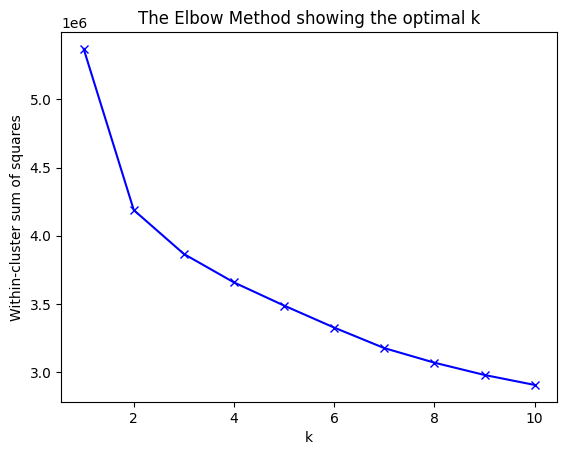

In [10]:
wcss_vec = optimal_kmeans_wcss(df_pca, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

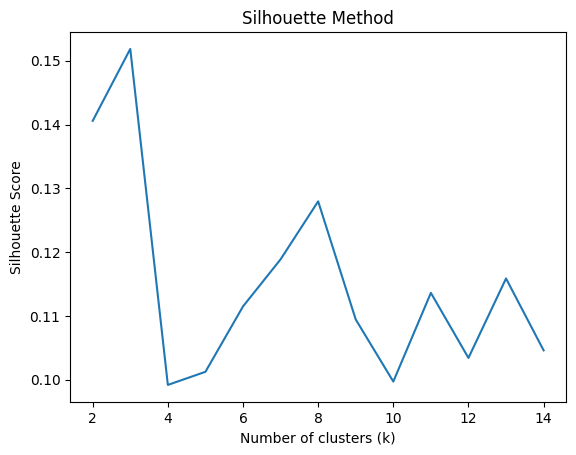

In [11]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50).fit(df_pca)
    score = silhouette_score(df, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 15), silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

In [12]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
cluster_labels = kmeans.fit_predict(df_pca)

visualise_clusters_umap_3d(umap_3d, cluster_labels, "KMeans")

In [13]:
kmeans = KMeans(n_clusters=8, random_state=42, n_init=50)
cluster_labels = kmeans.fit_predict(df_pca)

visualise_clusters_umap_3d(umap_3d, cluster_labels, 'Kmeans 8')

### Modele aglomeracyjne, GMM, DBSCAN, ...

Funkcja do ewaluacji modeli\
Metryki wybrane na podstawie: 
[Cluster validation techniques for genome expression data, Bolshakova and Azuaje, 2003](https://www.scss.tcd.ie/publications/tech-reports/reports.02/TCD-CS-2002-33.pdf)  

In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.base import clone

from scipy.spatial.distance import cdist


def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in unique_clusters:
        Xi = X[labels == i]
        intra_dists = cdist(Xi, Xi)
        intra_cluster_distances.append(np.max(intra_dists))

        for j in unique_clusters:
            if i < j:
                Xj = X[labels == j]
                inter_dists = cdist(Xi, Xj)
                inter_cluster_distances.append(np.min(inter_dists))

    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

def evaluate_models(X, models):
    """
    Parameters:
    - X: array-like, shape (n_samples, n_features)
    - models: dict of {name: clustering_model} (must have `.fit_predict()` method)

    Returns:
    - DataFrame with model evaluation metrics
    """
    results = []

    for name, model in models.items():
        clusterer = clone(model)
        labels = clusterer.fit_predict(X)

        silhouette = silhouette_score(X, labels)
        db_index = davies_bouldin_score(X, labels)
        dunn = dunn_index(X, labels)

        results.append({
            'Model': name,
            'Silhouette Score': silhouette,
            'Davies-Bouldin Index': db_index,
            'Dunn Index': dunn,
            'Num Clusters': len(np.unique(labels))
        })

    return pd.DataFrame(results).sort_values(by='Silhouette Score', ascending=False)

Modele testowane w poprzednim kamieniu milowym:

In [15]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture


models = {
    "KMeans (k=4)": KMeans(n_clusters=4, random_state=0),
    "KMeans (k=6)": KMeans(n_clusters=6, random_state=0),
    "Aglomarative, linkage='complete, 7": AgglomerativeClustering(n_clusters=7, linkage='complete'),
    "Aglomarative, linkage='complete, 8": AgglomerativeClustering(n_clusters=8, linkage='complete'),
    "Aglomarative, linkage='ward, 5": AgglomerativeClustering(n_clusters=5, linkage='ward'),
    "Aglomarative, linkage='ward', td = 500": AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=500),
    "GMM (n_components=4)": GaussianMixture(n_components=4),
    "GMM (n_components=5)": GaussianMixture(n_components=5),
    "GMM (n_components=6)": GaussianMixture(n_components=6),
    "GMM (n_components=7)": GaussianMixture(n_components=7)
}

results_df = evaluate_models(df_pca, models)
print(results_df)

                                    Model  Silhouette Score  \
4          Aglomarative, linkage='ward, 5          0.128705   
2      Aglomarative, linkage='complete, 7          0.127728   
3      Aglomarative, linkage='complete, 8          0.120143   
0                            KMeans (k=4)          0.108515   
5  Aglomarative, linkage='ward', td = 500          0.107684   
6                    GMM (n_components=4)          0.106028   
7                    GMM (n_components=5)          0.104262   
8                    GMM (n_components=6)          0.097324   
1                            KMeans (k=6)          0.091137   
9                    GMM (n_components=7)          0.083568   

   Davies-Bouldin Index  Dunn Index  Num Clusters  
4              2.218814    0.409617             5  
2              2.090922    0.450158             7  
3              2.075566    0.466790             8  
0              2.252080    0.213247             4  
5              2.303521    0.433289           

In [16]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(min_samples=5, eps=170)
cluster_labels = dbscan.fit_predict(df_pca)

visualise_clusters_umap_3d(umap_3d, cluster_labels, "DBSCAN")

In [17]:
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=7)
cluster_labels = gmm.fit_predict(df_pca)

visualise_clusters_umap_3d(umap_3d, cluster_labels, "GMM")

In [18]:
models = {
    "Agglomerative (complete, 7)": AgglomerativeClustering(linkage='complete', n_clusters=7),
    "Agglomerative (complete, 8)": AgglomerativeClustering(linkage='complete', n_clusters=8),
    "Agglomerative (ward, 5)": AgglomerativeClustering(linkage='ward', n_clusters=5),
    "KMeans (k=4)": KMeans(n_clusters=4, random_state=12),
    "KMeans (k=6)": KMeans(n_clusters=6,random_state=12),
    "KMeans (k=5)": KMeans(n_clusters=6,random_state=12)
}


for (name, model) in models.items():
    cluster_labels = model.fit_predict(df_pca)

    visualise_clusters_umap_3d(umap_3d, cluster_labels, name)
    

### GRID Search
Dobieramy hiperparametry an podstawie wcześniej zdefiniowanych metryk

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.base import clone
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in unique_clusters:
        Xi = X[labels == i]
        intra_dists = cdist(Xi, Xi)
        intra_cluster_distances.append(np.max(intra_dists))

        for j in unique_clusters:
            if i < j:
                Xj = X[labels == j]
                inter_dists = cdist(Xi, Xj)
                inter_cluster_distances.append(np.min(inter_dists))

    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

def evaluate_models_for_GRID(X, models):
    """
    Parameters:
    - X: array-like, shape (n_samples, n_features)
    - models: dict of {name: clustering_model} (must have `.fit_predict()` method)

    Returns:
    - DataFrame with model evaluation metrics
    """
    results = []

    for name, model in models.items():
        try:
            clusterer = clone(model)
            if hasattr(clusterer, 'fit_predict'):
                labels = clusterer.fit_predict(X)
            else:  # For GMM which uses predict instead of fit_predict
                labels = clusterer.fit(X).predict(X)
                
            # Skip evaluation if only one cluster found
            if len(np.unique(labels)) < 2:
                continue
                
            silhouette = silhouette_score(X, labels)
            db_index = davies_bouldin_score(X, labels)
            dunn = dunn_index(X, labels)

            results.append({
                'Model': name,
                'Silhouette Score': silhouette,
                'Davies-Bouldin Index': db_index,
                'Dunn Index': dunn,
                'Num Clusters': len(np.unique(labels[labels != -1]))  # Exclude noise for DBSCAN
            })
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            continue

    return pd.DataFrame(results).sort_values(by='Silhouette Score', ascending=False)

# Define parameter grids for each algorithm
param_grids = {
    'KMeans': {
        'n_clusters': range(3, 11),
        'init': ['k-means++', 'random'],
        'random_state': [0],
    },
    'Agglomerative': {
        'n_clusters': [None, 3, 4, 5, 6, 7, 8],
        'linkage': ['ward', 'complete', 'average', 'single'],
        'distance_threshold': [None, 100, 200, 250, 300, 350, 400, 450, 500, 600]
    },
    'GMM': {
        'n_components': range(2, 9),
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'random_state': [0]
    },
}

# Generate all model combinations
def generate_models():
    models = {}
    
    # KMeans models
    for n_clusters in param_grids['KMeans']['n_clusters']:
        for init in param_grids['KMeans']['init']:
            name = f"KMeans (k={n_clusters}, init='{init}')"
            models[name] = KMeans(n_clusters=n_clusters, init=init, random_state=0, n_init=50)
    
    # Agglomerative models
    for linkage in param_grids['Agglomerative']['linkage']:
        for n_clusters in param_grids['Agglomerative']['n_clusters']:
            for dist_thresh in param_grids['Agglomerative']['distance_threshold']:
                if n_clusters is None and dist_thresh is None:
                    continue  # Invalid combination
                if linkage == 'ward' and dist_thresh is not None:
                    name = f"Agglomerative (linkage='{linkage}', thresh={dist_thresh})"
                    models[name] = AgglomerativeClustering(
                        n_clusters=None, linkage=linkage, distance_threshold=dist_thresh)
                else:
                    if dist_thresh is not None:
                        continue  # Only use distance_threshold with ward
                    name = f"Agglomerative (linkage='{linkage}', k={n_clusters})"
                    models[name] = AgglomerativeClustering(
                        n_clusters=n_clusters, linkage=linkage)
    
    # GMM models
    for n_components in param_grids['GMM']['n_components']:
        for cov_type in param_grids['GMM']['covariance_type']:
            name = f"GMM (n={n_components}, cov='{cov_type}')"
            models[name] = GaussianMixture(
                n_components=n_components, covariance_type=cov_type, random_state=0)
    
    return models

In [20]:
models = generate_models()
results_df = evaluate_models_for_GRID(df_pca, models)

# Display top results sorted by Silhouette Score
print("Top 20 models by Silhouette Score:")
print(results_df.head(20))

# Also show sorted by other metrics
print("\nTop 20 models by Dunn Index:")
print(results_df.sort_values(by='Dunn Index', ascending=False).head(20))

print("\nTop 20 models by Davies-Bouldin Index (lower is better):")
print(results_df.sort_values(by='Davies-Bouldin Index').head(20))

Top 20 models by Silhouette Score:
                                         Model  Silhouette Score  \
52                  GMM (n=2, cov='spherical')          0.197242   
51                       GMM (n=2, cov='diag')          0.197242   
50                       GMM (n=2, cov='tied')          0.197242   
49                       GMM (n=2, cov='full')          0.197242   
0               KMeans (k=3, init='k-means++')          0.170625   
1                  KMeans (k=3, init='random')          0.170625   
37      Agglomerative (linkage='average', k=3)          0.167198   
25         Agglomerative (linkage='ward', k=3)          0.164305   
31     Agglomerative (linkage='complete', k=3)          0.159115   
32     Agglomerative (linkage='complete', k=4)          0.151445   
38      Agglomerative (linkage='average', k=4)          0.150517   
18  Agglomerative (linkage='ward', thresh=250)          0.148651   
19  Agglomerative (linkage='ward', thresh=300)          0.140413   
53           

Staramy się dobrać modele, które wypadają względnie dobrze we wszystkich metrykach. Odrzucamy oczywiste podziały na 2 klastry, oraz modele z bardzo zawyżoną liczbą klastrów typu 97, 73, 48 -- są to modele przetrenowane. 

In [21]:
models = {
    "Agglomerative (complete, 3)": AgglomerativeClustering(linkage='complete', n_clusters=3),
    "Agglomerative (complete, 5)": AgglomerativeClustering(linkage='complete', n_clusters=5),
    "Agglomerative (complete, 6)": AgglomerativeClustering(linkage='complete', n_clusters=6),
    "KMeans (k=3)": KMeans(n_clusters=3,random_state=12, n_init=50)}

for name, model in models.items():
    m = model
    cluster_labels = m.fit_predict(df_pca)
    
    visualise_clusters_umap_3d(umap_3d, cluster_labels, name)

In [22]:
from sklearn.cluster import AgglomerativeClustering


models = {
    "KMeans (k=4)": KMeans(n_clusters=3, random_state=42, n_init=50),
    "Aglomarative, linkage='complete, 7": AgglomerativeClustering(n_clusters=3, linkage='complete'),
}

results_df = evaluate_models(df_pca, models)
print(results_df)

                                Model  Silhouette Score  Davies-Bouldin Index  \
0                        KMeans (k=4)          0.170625              1.785807   
1  Aglomarative, linkage='complete, 7          0.159115              2.073756   

   Dunn Index  Num Clusters  
0    0.381502             3  
1    0.403014             3  


Wybrane przez nas metryki wskazują na 2 najlepsze modele: AgglomerativeClustering(linkage='complete', n_clusters=3) oraz KMeans(n_clusters=3,random_state=12, n_init=50). Patrzymy, jak teraz te modele zachowują się dla danych walidacyjnych.

## Perforamnce klasyfikacji dla klastrów

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
import shap

agg = AgglomerativeClustering(linkage='complete', n_clusters=3)
labels = agg.fit_predict(df_pca)

X = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])
y = labels

# podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


# Klasyfikator
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


# Obliczenie wartości SHAP
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

print("Accuracy on test set:", clf.score(X_test, y_test))

Accuracy on test set: 0.8461538461538461


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

kmeans = KMeans(n_clusters=3, random_state=42, n_init=50).fit(df_pca)
labels = kmeans.fit_predict(df_pca)

X = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])
y = labels

# podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


# Klasyfikator
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


# Obliczenie wartości SHAP
explainer = shap.Explainer(clf, X_train)
shap_values = explainer(X_test)

print("Accuracy on test set:", clf.score(X_test, y_test))

Accuracy on test set: 0.9615384615384616


KMeans lepiej działa z klasyfikatorem, co potrzbne nam jest do relizacji celu biznesowego -- przyporządkowywania pacjętów do klastrów. Ostatecznie wybieramy więc KMeans.

## Interpretacja klastrów

Tworzymy ranking cech, które najbardziej wpływają na decyzję modelu o przypisaniu próbki do danego klastra, na podstawie średnich wartości bezwzględnych SHAP.

In [25]:
import numpy as np
shap_mean = np.abs(shap_values.values[:, :, 0]).mean(axis=0)

shap_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_SHAP': shap_mean
}).sort_values(by='Mean_SHAP', ascending=False)

print(shap_df.head(15))

   Feature  Mean_SHAP
0      PC1   0.191860
36    PC37   0.017452
1      PC2   0.013209
22    PC23   0.010344
41    PC42   0.008851
21    PC22   0.006783
73    PC74   0.006620
40    PC41   0.006138
48    PC49   0.005689
31    PC32   0.005688
10    PC11   0.005526
27    PC28   0.005455
46    PC47   0.005150
38    PC39   0.005012
2      PC3   0.004896


Skupimy się na 3 najlepszych zmiennych z PCA, czyli PC1, PC2 i PC47.

In [26]:
top_pcs = ['PC1', 'PC37', 'PC2']

gene_names = [col for col in df.columns if col not in ['cluster', 'other_non_gene_columns']]

loadings = pd.DataFrame(
    data=pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=gene_names
)


df_scaled_df = pd.DataFrame(df_scaled, columns=gene_names)

# dodajemy etykiety klastrów
df_scaled_df['cluster'] = labels
# Sumujemy wartości bezwzględne ładunków dla tych PC, by zobaczyć, które geny najbardziej wpływają na te składowe:
top_genes = loadings[top_pcs].abs().sum(axis=1).sort_values(ascending=False).head(15)

print("Top geny wpływające na najważniejsze PC:")
print(top_genes)

Top geny wpływające na najważniejsze PC:
1559980_at      0.026512
219576_at       0.026008
236313_at       0.025717
227554_at       0.025511
208270_s_at     0.025315
1552848_a_at    0.025162
217920_at       0.025128
218936_s_at     0.025095
232362_at       0.025066
228673_s_at     0.025058
232327_at       0.024887
223533_at       0.024590
242947_at       0.024584
1552870_s_at    0.024564
213368_x_at     0.024533
dtype: float64


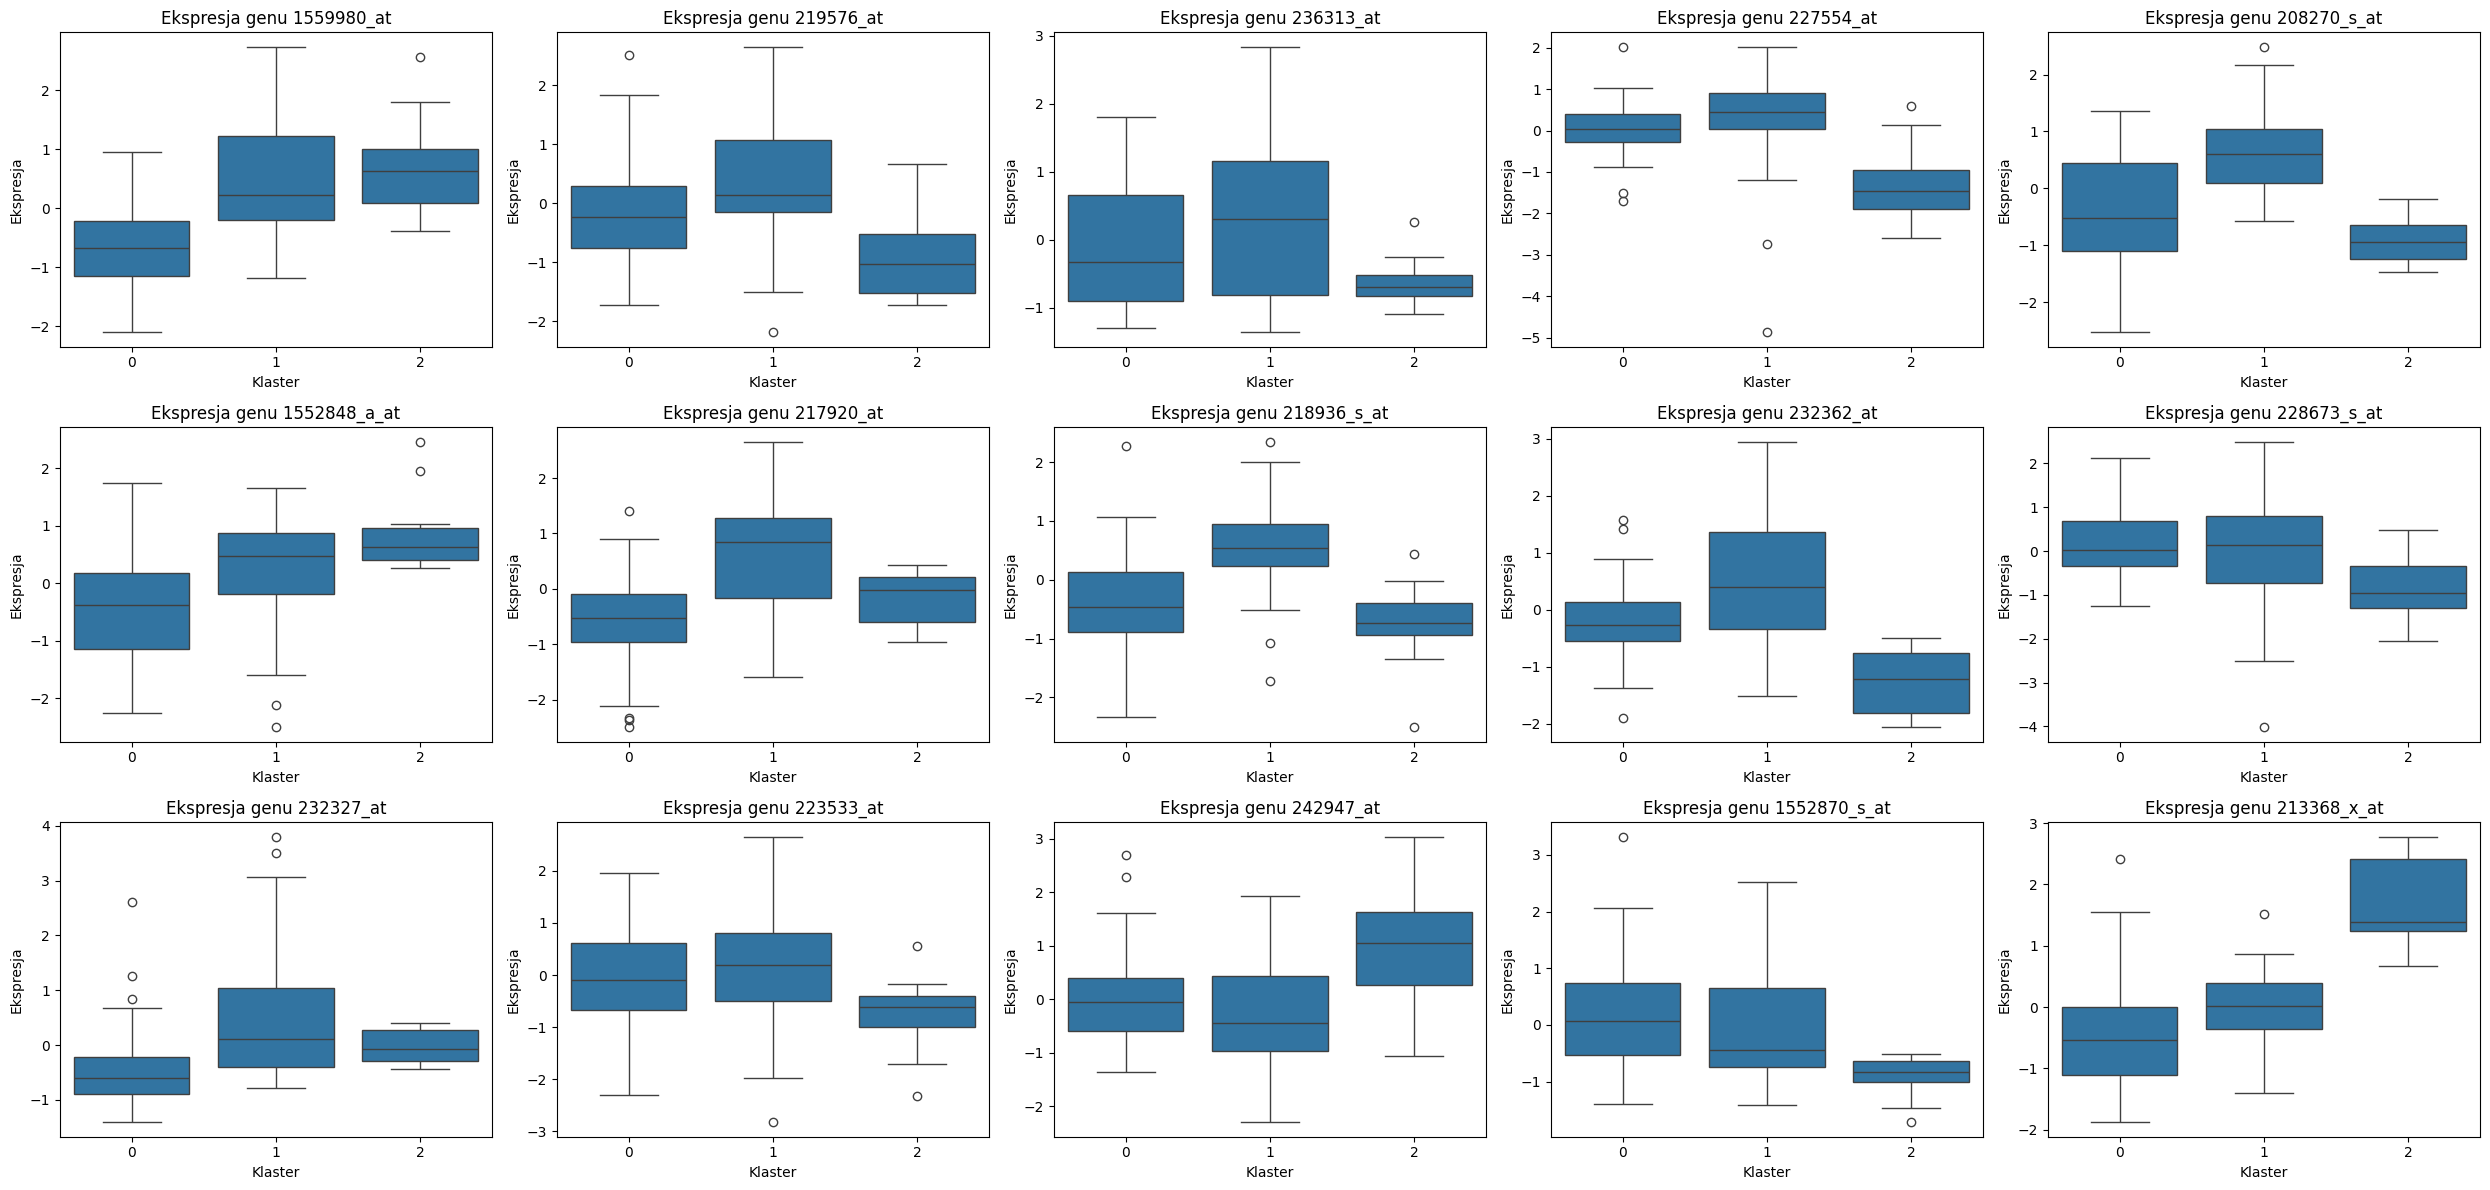

In [27]:
# Parametry siatki
top_genes_list = top_genes.index.tolist() 

num_plots = len(top_genes_list)
cols = 5  # liczba kolumn
rows = (num_plots + cols - 1) // cols  # zaokrąglenie w górę

# Tworzymy siatkę wykresów
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # spłaszczamy tablicę osi

for i, gene in enumerate(top_genes_list):
    sns.boxplot(x='cluster', y=gene, data=df_scaled_df, ax=axes[i])
    axes[i].set_title(f'Ekspresja genu {gene}')
    axes[i].set_xlabel('Klaster')
    axes[i].set_ylabel('Ekspresja')

# Ukrywamy puste subploty jeśli jest ich więcej niż potrzebujemy
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Widać, że istnieją pewne podgrupy genów charakteryzują się spójnym profilem ekspresji w podziale na klastry.
Np. gen 241764_at oraz 219291_at.

In [28]:

# key_genes = ['219256_s_at', '212419_at', '230252_at', '217762_s_at', '217764_s_at',
#              '221840_at', '227791_at', '243748_at', '233157_x_at', '231710_at', '1553729_s_at']

# przeprowadzamy test statystyczny kruskala dla każdego genu
from scipy.stats import kruskal

for gene in top_genes_list:
    groups = [df_scaled_df[df_scaled_df['cluster'] == c][gene] for c in df_scaled_df['cluster'].unique()]
    stat, p = kruskal(*groups)
    print(f'Gen: {gene}, statystyka: {stat:.3f}, p-value: {p:.3e}')

# uczymy klasyfikator na najbardziej kluczowych genach
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X_key = df_scaled_df[top_genes_list]
y = df_scaled_df['cluster']

clf = RandomForestClassifier(random_state=12)
scores = cross_val_score(clf, X_key, y, cv=5)
print(f'Skuteczność klasyfikacji na kluczowych genach: {scores.mean():.3f} ± {scores.std():.3f}')


Gen: 1559980_at, statystyka: 36.245, p-value: 1.348e-08
Gen: 219576_at, statystyka: 19.812, p-value: 4.987e-05
Gen: 236313_at, statystyka: 6.395, p-value: 4.087e-02
Gen: 227554_at, statystyka: 21.206, p-value: 2.485e-05
Gen: 208270_s_at, statystyka: 38.580, p-value: 4.193e-09
Gen: 1552848_a_at, statystyka: 20.873, p-value: 2.934e-05
Gen: 217920_at, statystyka: 31.020, p-value: 1.837e-07
Gen: 218936_s_at, statystyka: 32.295, p-value: 9.710e-08
Gen: 232362_at, statystyka: 29.246, p-value: 4.460e-07
Gen: 228673_s_at, statystyka: 9.531, p-value: 8.517e-03
Gen: 232327_at, statystyka: 24.867, p-value: 3.983e-06
Gen: 223533_at, statystyka: 9.049, p-value: 1.084e-02
Gen: 242947_at, statystyka: 10.014, p-value: 6.691e-03
Gen: 1552870_s_at, statystyka: 16.339, p-value: 2.832e-04
Gen: 213368_x_at, statystyka: 34.023, p-value: 4.093e-08
Skuteczność klasyfikacji na kluczowych genach: 0.846 ± 0.071


In [29]:
# Grupowanie po klastrach i średnia ekspresja genów
mean_expression = df_scaled_df.groupby('cluster')[top_genes_list].mean()

print(mean_expression)

         1559980_at  219576_at  236313_at  227554_at  208270_s_at  \
cluster                                                             
0         -0.623060  -0.168102  -0.135644   0.058328    -0.406744   
1          0.492476   0.413285   0.295281   0.253992     0.656882   
2          0.704130  -0.957175  -0.616068  -1.293579    -0.912361   

         1552848_a_at  217920_at  218936_s_at  232362_at  228673_s_at  \
cluster                                                                 
0           -0.418441  -0.546614    -0.387619  -0.191007     0.164185   
1            0.229874   0.621123     0.595407   0.509421     0.031829   
2            0.885529  -0.155733    -0.744329  -1.250508    -0.846652   

         232327_at  223533_at  242947_at  1552870_s_at  213368_x_at  
cluster                                                              
0        -0.428582  -0.001919   0.006853      0.204881    -0.408516  
1         0.461099   0.187294  -0.247250      0.002751     0.012451  
2       

## Wizualizacja klastrów na zbiorze walidacyjnym

Modele aglomeracyjne nie posiadają funkcji predict (od razu trzeba robić fit i predict), przez co nie możemy zaaplikować powstałych klastrów do odosobnionego zbioru danych. Robimy więc klasyfikację na zbiorze walidacyjnym bazując na wcześniej otrzymanych klastrach, i predict na zbiorze walidacyjnym

In [30]:
df_scaled_validation = scaler.transform(df_validation)
df_pca_validation = pca.transform(df_scaled_validation)
umap_3d_validation = reducer.transform(df_pca_validation)

/Users/lila/CuMiDaKlasteryzacja/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

kmeans = KMeans(n_clusters=3, random_state=42, n_init=50).fit(df_pca)
labels = kmeans.fit_predict(df_pca)

X = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])
y = labels

# podział na trening i test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


# Klasyfikator
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
df_pca_val_df = pd.DataFrame(df_pca_validation, columns=X.columns)
val_pred_labels = clf.predict(df_pca_val_df)

visualise_clusters_umap_3d(umap_3d_validation, val_pred_labels, "Validation (Predicted Clusters)")


### Wybrany model: Kmeans, 3 klastry

In [36]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=50)
cluster_labels = kmeans.fit_predict(df_pca)

visualise_clusters_umap_3d(umap_3d, cluster_labels, "KMeans")

In [37]:
models = {
    "KMeans (k=3)": KMeans(n_clusters=3, random_state=0, n_init=50),
}

results_df = evaluate_models(df_pca, models)
print(results_df)

          Model  Silhouette Score  Davies-Bouldin Index  Dunn Index  \
0  KMeans (k=3)          0.170625              1.785807    0.381502   

   Num Clusters  
0             3  


Komentarze do prezentacji: W prezentacji końcowej pokazałyśmy model aglomeratywny, ale model KMeans okazał się ostatecznie lepszy pod względem metryk (trochę lepsze wyniki) oraz działania z klasyfikatorem. Klastry przewidywane na zbiorach testowym i walidacyjnym nieznacznie różnią się pomiędzy tymi modelami. 

Komentarze do walidacji: nei dostałyśmy żadnego negatywanego feedbacku od zespołu walidacyjnego, do którego mogłybyśmy się odnieść.